In [1]:
# Data preprocessing utils : 
from torchvision.transforms import Compose
from torchvision import transforms
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt
# my defined model
from utils.acdc_dataset import *
from utils.funcs import *
from utils.vqvae import *

In [2]:
######################## Parameters ######################

# dataset params :
L = 128  # length of input images
data_modality = 'MRI'  # either 'SEG' to use segmentation dataset or 'MRI' for gray-scale MRIs
loss_func = 'L1'

# training params
BATCH_SIZE = 32
lr = 5e-4
epochs = 100
model_name = 'saved_models/mri/512_64_4_smoothl1.pth'


# model hyper-params :
K =  512 # num_embeddings
D =  64  # embedding_dim 
downsampling_factor = 4

use_residual = False # swicth to True if wants to use RQ-VAE
num_quantizers = 0
shared_codebook = False

beta = .25
decay = .8

kmeans_init = True
kmeans_iters = 10



In [3]:
#################### dataset init ######################
dataset_path = "/home/ids/ihamdaoui-21/ACDC/database"

train_set_path = os.path.join(dataset_path, "training")
test_set_path  = os.path.join(dataset_path, "testing")


train_dataset = load_dataset(train_set_path, modality= data_modality)
test_dataset  = load_dataset(test_set_path, modality= data_modality)


if data_modality == 'SEG':
    input_transforms = Compose([
        transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
        One_hot_Transform(num_classes=4)
        ])
else : 
    input_transforms = Compose([
        transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
        PercentileClip(lower_percentile=1, upper_percentile=99),
        MinMaxNormalize(min_value=0.0, max_value=1.0),
        ])


TrainDataset = ACDC_Dataset(data = train_dataset, transforms= input_transforms) 
TestDataset  = ACDC_Dataset(data = test_dataset, transforms= input_transforms)

TrainLoader  = DataLoader(TrainDataset, batch_size = BATCH_SIZE, shuffle = True)
TestLoader   = DataLoader(TestDataset , batch_size = BATCH_SIZE, shuffle = False)



In [4]:
model_path = 'saved_models/mri/512_64_4_l1_std.pth'

model =  VQVAE(embedding_dim= D,
                num_embeddings= K,
                downsampling_factor= downsampling_factor,
                residual = use_residual,
                num_quantizers = num_quantizers,
                shared_codebook = shared_codebook,
                beta = beta,
                decay = decay,
                data_mod = data_modality
                    )

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model = model.to(device)

/tmp/ipykernel_1327724/1106437802.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)['model_state_dict'])


In [5]:
vis_batch = next(iter(TestLoader)).to(device)

batch_hat = reconstruct_logits(vis_batch, model)

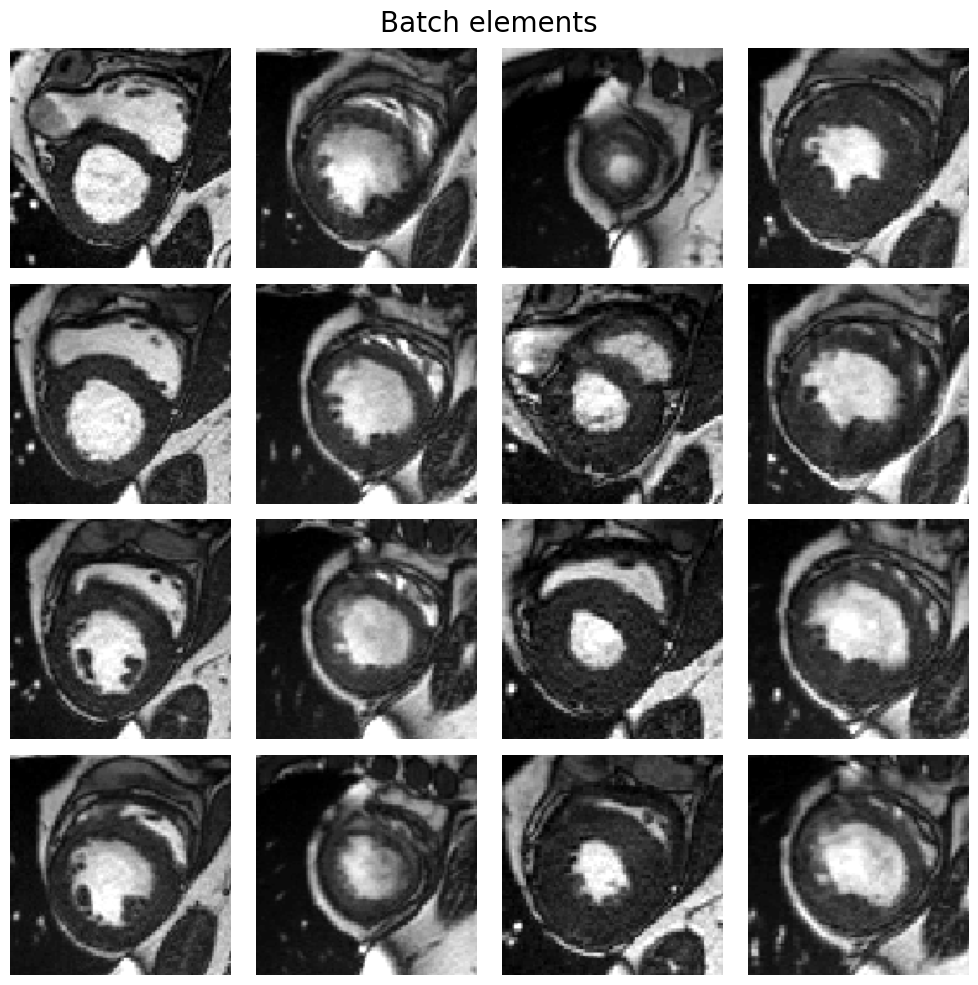

In [7]:
visualize_batch_MRI(vis_batch.to('cpu').numpy())

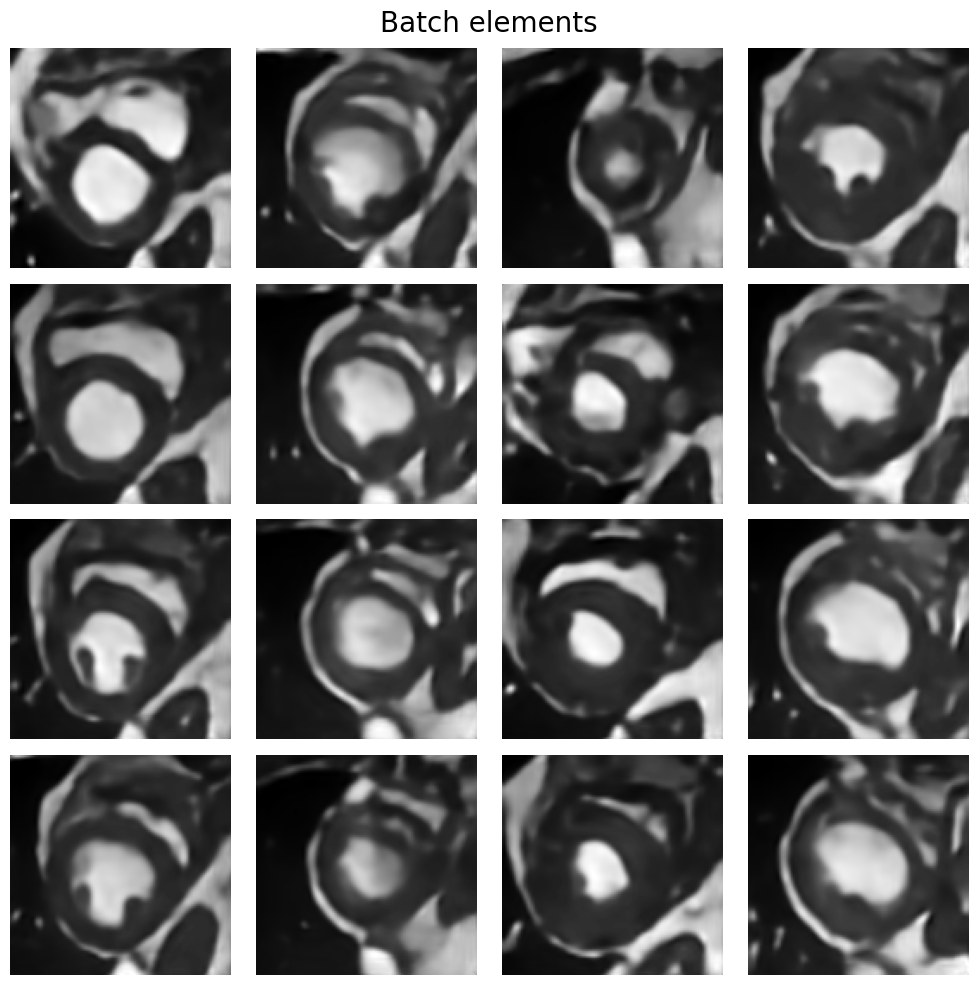

In [9]:
visualize_batch_MRI(batch_hat.detach().to('cpu').numpy())

In [10]:
loss_func = 'MSE'
model_path = 'saved_models/mri/512_64_4_mse.pth'

model =  VQVAE(embedding_dim= D,
                num_embeddings= K,
                downsampling_factor= downsampling_factor,
                residual = use_residual,
                num_quantizers = num_quantizers,
                shared_codebook = shared_codebook,
                beta = beta,
                decay = decay,
                data_mod = data_modality
                    )

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model = model.to(device)

/tmp/ipykernel_1327724/343314572.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)['model_state_dict'])


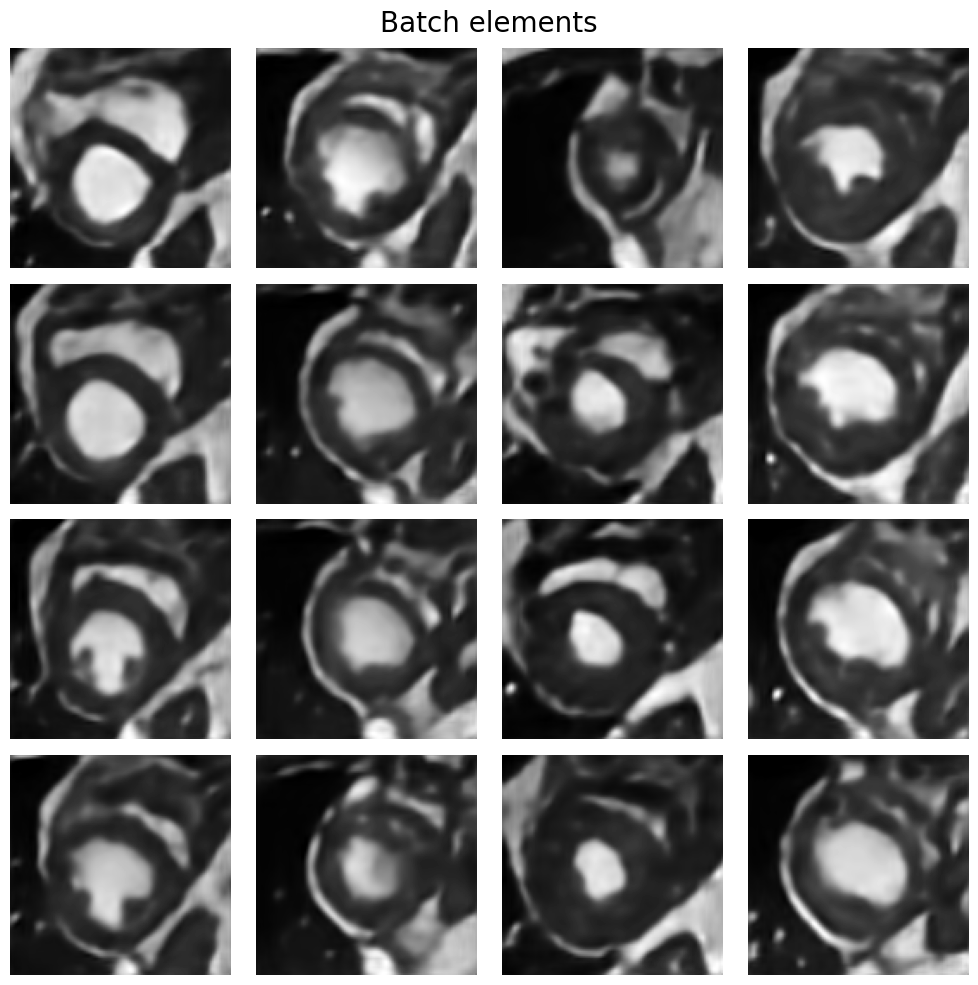

In [11]:
batch_hat = reconstruct_logits(vis_batch, model)
visualize_batch_MRI(batch_hat.detach().to('cpu').numpy())